### Dimensionality Reduction & Representation Learning 

In [96]:
### Import Pytorch and other relevant packages
import torch
import torch.nn as nn
### Import MNIST dataset 
from torchvision.datasets import MNIST
### Load Numpy and Matplotlib
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

In [97]:
### Download MNIST data 
# 4.1.1
train_set = MNIST('.',download=True)
test_set = MNIST('.',train=False)

In [98]:
### Load the training and test data [x], along with labels [y]
xTrain, yTrain = torch.load('MNIST/processed/training.pt')
xTest, yTest = torch.load('MNIST/processed/test.pt')

Training samples: 60000
Test samples: 10000


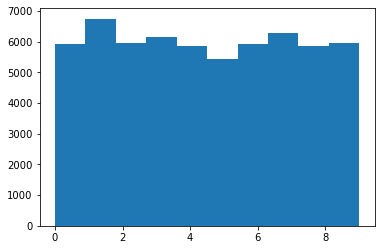

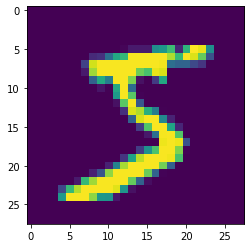

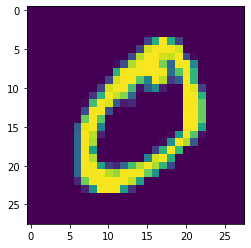

In [99]:
### Get to know your data
# 4.1.2 - Sample Size
print('Training samples:', len(xTrain))
print('Test samples:', len(xTest))

# 4.1.3 - Histogram
plt.figure(0)
plt.hist(yTrain)

# 4.1.4 - Visualize
for i in range(2):
    plt.figure(i+1)
    plt.imshow(xTrain[i])

### Subset of data with [0,1,2,3,4] classes only
### Save copies of torch data in numpy as sklearn uses numpy arrays
# 4.2.1 - Smaller Subset
xTrain, xTest, yTrain, yTest = train_test_split(xTrain, yTrain, test_size=0.01, train_size=0.1)
xTrain, yTrain = xTrain.numpy(), yTrain.numpy()
xTest, yTest = xTest.numpy(), yTest.numpy()

xTrain_s = xTrain[yTrain <= 4]
yTrain_s = yTrain[yTrain <= 4]
xTest_s = xTest[yTest <= 4]
yTest_s = yTest[yTest <= 4]

### Reshape the images from Nx28x28 to Nx784
# 4.1.5 - Reshape
xTrain_sr, xTest_sr = [],[]
for i in range(len(xTrain_s)):
    xTrain_sr.append(xTrain_s[i].reshape(-1))
for i in range(len(xTest_s)):
    xTest_sr.append(xTest_s[i].reshape(-1))
    
xTrain_sr, xTest_sr = np.array(xTrain_sr), np.array(xTest_sr)

### Principal Component Analysis
Use the sklearn package to perform the PCA tasks. 

Total variance explained:  0.9738003842611267


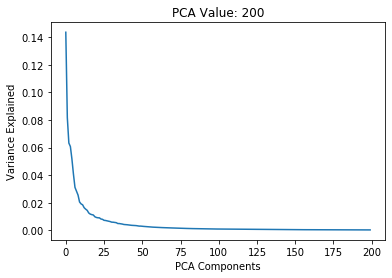

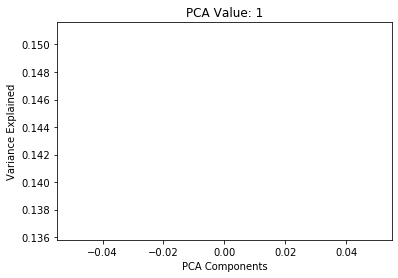

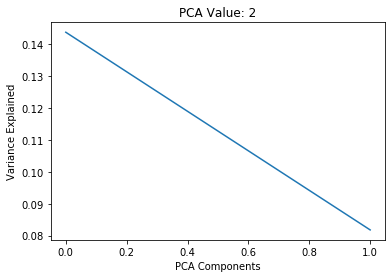

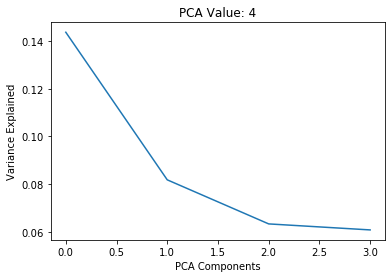

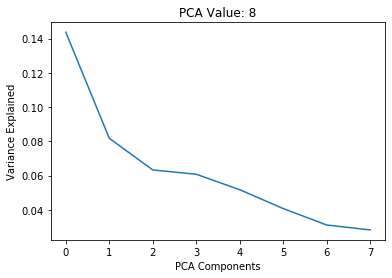

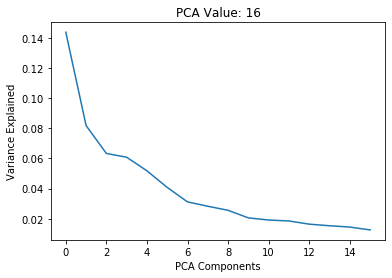

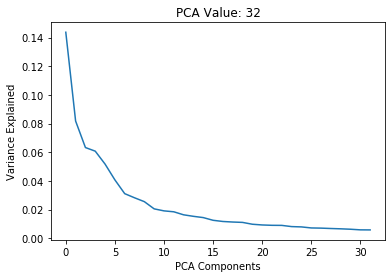

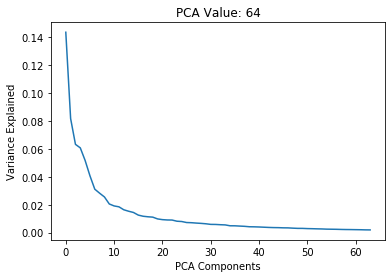

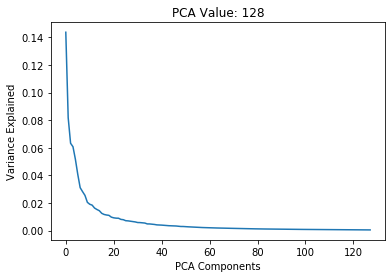

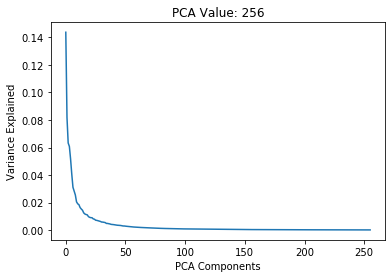

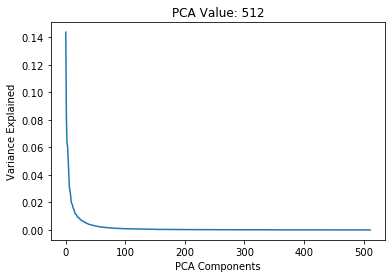

In [100]:
from sklearn.decomposition import PCA
# 4.2.3 - PCA
pca = PCA(n_components=200)
pca.fit(xTrain_sr)

# 4.2.4 - Plot, Ratio, Sum
plt.figure(0)
plt.plot(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("PCA Value: 200")
plt.xlabel("PCA Components")
plt.ylabel("Variance Explained")
total_var_e = sum(pca.explained_variance_ratio_)
print("Total variance explained: ", total_var_e)

# 4.2.5 - Plot D = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
D = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]
for i in range(len(D)):
    plt.figure(i+1)
    pca_t = PCA(n_components=D[i])
    pca_t.fit(xTrain_sr)
    plt.plot(range(len(pca_t.explained_variance_ratio_)), pca_t.explained_variance_ratio_)
    plt.title(f'PCA Value: {D[i]}')
    plt.xlabel("PCA Components")
    plt.ylabel("Variance Explained")
    '''
    total_var_e = sum(pca_t.explained_variance_ratio_)
    print("Total variance explained: ", total_var_e)
    '''

Shape pre PCA:  (3023, 784)
Shape aft PCA:  (3023, 2)


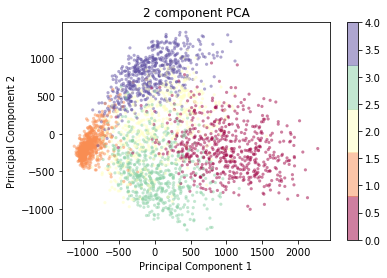

In [112]:
### Sample plot to visualize the latent space
### If x1, x2 are the 1st and 2nd dimensions of 
### dimensionality reduced data, with labels y.
# 4.2.6 - PCA D=2, Plot
pca_t = PCA(n_components=2)
components = pca_t.fit_transform(xTrain_sr)
print("Shape pre PCA: ", xTrain_sr.shape)
print("Shape aft PCA: ", components.shape)

plt.scatter(components[:,0], components[:,1], 
            s=10, c=yTrain_s[:], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
plt.colorbar();

Shape pre PCA:  (287, 784)
Shape aft PCA:  (287, 2)


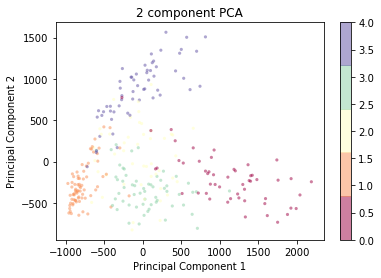

In [102]:
# 4.2.7 - PCA D=2, Plot testset
pca_t = PCA(n_components=2)
components_test = pca_t.fit_transform(xTest_sr)
print("Shape pre PCA: ", xTest_sr.shape)
print("Shape aft PCA: ", components_test.shape)

plt.scatter(components_test[:,0], components_test[:,1], 
            s=10, c=yTest_s[:], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 5))
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2 component PCA')
plt.colorbar();

In [115]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score

# 4.2.8 - KMeans
def score(pcs, labels):
    preds = kmeans.predict(pcs)
    return adjusted_rand_score(preds, labels)
    
kmeans = KMeans(n_clusters=5)
kmeans.fit(components)
print(f'Accuracy training: {score(components, yTrain_s)}%')
print(f'Accuracy testing: {score(components_test, yTest_s)}%')

Accuracy training: 0.4973698807862855%
Accuracy testing: 0.518063340985218%


### Autoencoders
Below the Pytorch classes for an autoencoder and variational autoencoder, along with a training script 
are provided with some key components to be filled in by you. 

In [116]:
### Import additional torch modules
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
from torch.autograd import Variable

In [117]:
### Set parameters for the model
torch.manual_seed(42) # set fixed random seed for reproducibility

batch_size = 128
epochs = 100
latent_dim = 2
lr = 1e-3

print(torch.cuda.get_device_name(0))
cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

GeForce GTX 1660 Ti with Max-Q Design
Using device(type='cuda')


In [118]:
### Download MNIST data and apply transform to tensor
def min_max_normalization(tensor, min_value, max_value):
    min_tensor = tensor.min()
    tensor = (tensor - min_tensor)
    max_tensor = tensor.max()
    tensor = tensor / max_tensor
    tensor = tensor * (max_value - min_value) + min_value
    return tensor

img_transform = transforms.Compose([
    transforms.Lambda(lambda tensor:min_max_normalization(tensor, 0, 1)),
    transforms.Lambda(lambda tensor:np.around(tensor)),
#     transforms.ToTensor()
])

# train_set = MNIST('.', transform=img_transform, download=True)
xTrain_sn = img_transform(xTrain_s)
xTrain_t = torch.from_numpy(xTrain_sn).to(torch.float32)
yTrain_t = torch.from_numpy(yTrain_s).to(torch.float32)
train_set = torch.utils.data.TensorDataset(xTrain_t, yTrain_t)

xTest_sn = img_transform(xTest_s)
xTest_t = torch.from_numpy(xTest_sn).to(torch.float32)
yTest_t = torch.from_numpy(yTest_s).to(torch.float32)
test_set = torch.utils.data.TensorDataset(xTest_t, yTest_t)

In [119]:
### Torch uses a specialised dataloader for faster access
### It also has some nice properties to do efficient prefetching,
### batching and data augmentation
N = len(train_set)
nTrain = int(0.8*N)
nValid = N-nTrain

valid_set, train_set = random_split(train_set,(nValid,nTrain))
print("Using nTrain: %d, nValid: %d "%(nTrain, nValid))

train_loader = torch.utils.data.DataLoader(train_set,
    batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_set,
    batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set,
    batch_size=batch_size, shuffle=True)

Using nTrain: 2418, nValid: 605 


In [127]:
### Autoencoder class
class AE(nn.Module):
    def __init__(self,latent_dim):
        super(AE, self).__init__()
        
        # 4.3.1 - Encoder AE
        ### Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, latent_dim),
            nn.ReLU(True))
        
        # 4.3.2 - Decoder AE
        ### Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 784),
            nn.Sigmoid())

    def forward(self, x):
        ### Autoencoder returns the reconstruction 
        ### and latent representation
        z = self.encoder(x)
        xHat = self.decoder(z)
        return xHat, z 

def to_img(x):
    x = x.view(x.size(0), 1, 28, 28)
    return x
    
# 4.3.3 - Optimization AE
model = AE(latent_dim).cuda()
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

In [131]:
#### Training script for autoencoder
for epoch in range(epochs):
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        
        output, z = model(img)
        loss = criterion(output, img)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if epoch % 30 == 0:
        print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, epochs, loss.data))
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu().data)
        save_image(x, './test_ae/x_{}.png'.format(epoch))
        save_image(x_hat, './test_ae/x_hat_{}.png'.format(epoch))
        print('saved images.')
        
#torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:0.2135
saved images.
epoch [31/100], loss:0.1959
saved images.
epoch [61/100], loss:0.1927
saved images.
epoch [91/100], loss:0.1922
saved images.


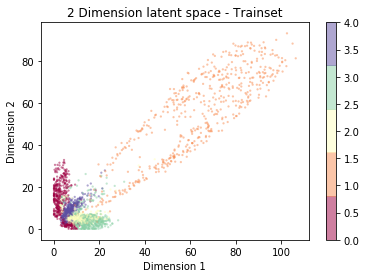

In [132]:
# 4.3.4 - visualization latent space - Trainset
latent_space = []
labels = []
for data in train_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    
    output, z = model(img)
    latent_space.append(z)
    labels.append(label)

# plot
for i in range(len(latent_space)):
    plt.scatter(latent_space[i][:,0].cpu().data, latent_space[i][:,1].cpu().data, 
                s=5, c=labels[i], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 5))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2 Dimension latent space - Trainset')
plt.colorbar()

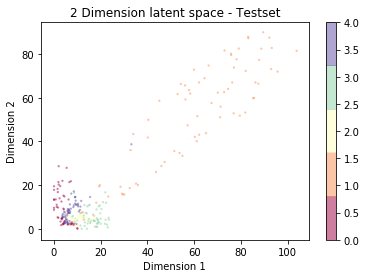

In [133]:
# 4.3.4 - visualization latent space - Testset
latent_space_test = []
labels = []
for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    
    output, z = model(img)
    latent_space_test.append(z)
    labels.append(label)
    
# plot
for i in range(len(latent_space_test)):
    plt.scatter(latent_space_test[i][:,0].cpu().data, latent_space_test[i][:,1].cpu().data, 
                s=5, c=labels[i], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 5))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2 Dimension latent space - Testset')
plt.colorbar()

### Variational Autoencoders

In [134]:
# Reconstruction + KL divergence losses summed over all elements and batch
def elbo_loss(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE, KLD


class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        
        # 4.4.1 - Encoder VAE
        ### Encoder layers
        self.encoder = nn.Sequential(
            nn.Linear(784, 32),
            nn.ReLU(True),
            nn.Linear(32, 16),
            nn.ReLU(True),
            nn.Linear(16, 2*latent_dim))
        
        # 4.4.3 - Decoder VAE
        ### Decoder layers
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 16),
            nn.ReLU(True),
            nn.Linear(16, 32),
            nn.ReLU(True),
            nn.Linear(32, 784),
            nn.Sigmoid())
    
    # 4.4.2 - Reparameterisation
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        z = mu.add(eps.mul(std))
        return z
    
    def forward(self, x):
        x = self.encoder(x)
        mu = x[:, :latent_dim]
        logvar = x[:, latent_dim:]
        z = self.reparameterize(mu, logvar)
        xHat = self.decoder(z)
        return xHat, mu, logvar
    
    def generate_samples(self, z):
        xHat = self.decoder(z)
        return xHat

model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

In [135]:
#### Training script for variational autoencoder
list_ELBO = []
list_BCE = []
list_KLD = []
epochs_vae = 100
for epoch in range(epochs_vae):
    train_loss = 0
    epoch_elbo = 0
    epoch_bce = 0
    epoch_kld = 0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        
        output, mu, logvar = model(img)
        BCE, KLD = elbo_loss(output, img, mu, logvar)
        loss = BCE + KLD
        
        epoch_elbo += loss
        epoch_bce += BCE
        epoch_kld += KLD
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    
    list_ELBO.append(epoch_elbo/len(train_loader))
    list_BCE.append(epoch_bce/len(train_loader))
    list_KLD.append(epoch_kld/len(train_loader))
    if epoch % 30 == 0:
        print('epoch [{}/{}], loss:{:.4f}'
          .format(epoch + 1, epochs_vae, train_loss/len(train_loader.dataset)))
        x = to_img(img.cpu().data)
        x_hat = to_img(output.cpu().data)
        save_image(x, './test_vae/x_{}.png'.format(epoch))
        save_image(x_hat, './test_vae/x_hat_{}.png'.format(epoch))
        print('saved images.')
        
#torch.save(model.state_dict(), './sim_autoencoder.pth')

epoch [1/100], loss:532.8891
saved images.
epoch [31/100], loss:170.8899
saved images.
epoch [61/100], loss:161.2963
saved images.
epoch [91/100], loss:155.7085
saved images.


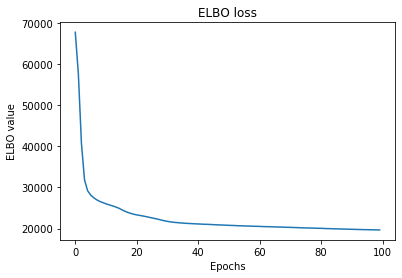

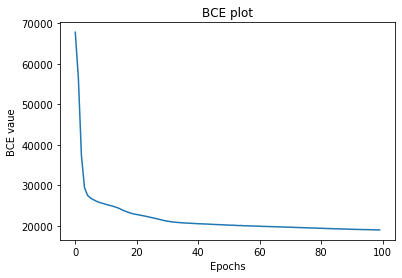

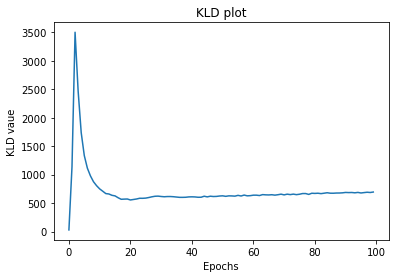

In [136]:
# 4.4.4 - Plot ELBO, BCE, KLD
def plot_loss(number, x, y, title, x_name, y_name):
    plt.figure(number)
    plt.plot(range(len(x)), y)
    plt.title(title)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

plot_loss(10, list_ELBO, list_ELBO, "ELBO loss", "Epochs", "ELBO value")
plot_loss(11, list_BCE, list_BCE, "BCE plot", "Epochs", "BCE vaue")
plot_loss(12, list_KLD, list_KLD, "KLD plot", "Epochs", "KLD vaue")

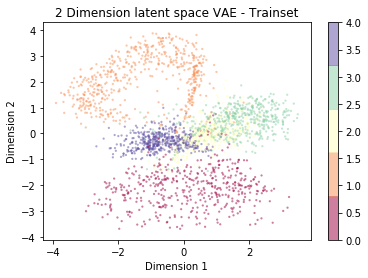

In [137]:
# 4.3.4 - visualization latent space - Trainset
list_mu = []
labels = []
for data in train_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    
    output, mu, logvar = model(img)
    list_mu.append(mu)
    labels.append(label)

# plot
for i in range(len(list_mu)):
    plt.scatter(list_mu[i][:,0].cpu().data, list_mu[i][:,1].cpu().data, 
                s=5, c=labels[i], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 5))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2 Dimension latent space VAE - Trainset')
plt.colorbar()

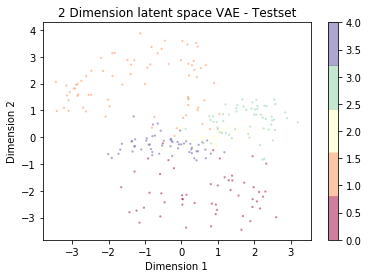

In [138]:
# 4.3.4 - visualization latent space - Testset
list_mu_test = []
labels = []
for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    img = Variable(img).cuda()
    
    output, mu, logvar = model(img)
    list_mu_test.append(mu)
    labels.append(label)

# plot
for i in range(len(list_mu_test)):
    plt.scatter(list_mu_test[i][:,0].cpu().data, list_mu_test[i][:,1].cpu().data, 
                s=5, c=labels[i], edgecolor='none', alpha=0.5, cmap=plt.cm.get_cmap('Spectral', 5))
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('2 Dimension latent space VAE - Testset')
plt.colorbar()

In [76]:
# 4.4.6 - Generate samples
sample_size = 32
step = 6/sample_size
samples = []
for i in range(sample_size):
    samples.append([-3+i*step, 0])

sample_z = Variable(torch.FloatTensor(samples)).cuda()
sample_xhat = model.generate_samples(sample_z).cpu()

sample_img = to_img(sample_xhat.cpu().data)
save_image(sample_img, './test_vae_samples/samples.png')